In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../../data/2023w6.csv")

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.


In [4]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
# Filter data based on condition
df = df[(df["ocean_proximity"] == '<1H OCEAN') | (df["ocean_proximity"] == 'INLAND')]
# alernate option
# df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [8]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

In [11]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [12]:
df.fillna(value=0, inplace=True)

In [15]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [16]:
import numpy as np
df.loc[:, 'median_house_value'] = np.log1p(df['median_house_value'])

In [23]:
from sklearn.model_selection import train_test_split

def split_train_val_test_dataset(df):
    df.fillna(value=0, inplace=True)
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train['median_house_value'].values
    y_val = df_val['median_house_value'].values
    y_test = df_test['median_house_value'].values
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    return df_train, df_val, df_test, y_train, y_val, y_test

In [24]:
df_train, df_val, df_test, y_train, y_val, y_test = split_train_val_test_dataset(df)

In [25]:
from sklearn.feature_extraction import DictVectorizer

def trun_train_dataframe_into_matrices(df):
    dv = DictVectorizer(sparse=False)
    df_dict = df.to_dict(orient='records')
    X = dv.fit_transform(df_dict)
    return dv, X

In [26]:
def trun_val_dataframe_into_matrices(df, dv):
    df_dict = df.to_dict(orient='records')
    X = dv.transform(df_dict)
    return X

In [27]:
def trun_dataframe_into_matrices(df_train, df_val):
    dv, X_train = trun_train_dataframe_into_matrices(df_train)
    X_val = trun_val_dataframe_into_matrices(df_val, dv)
    return X_train, X_val, dv

In [28]:
X_train, X_val, dv = trun_dataframe_into_matrices(df_train, df_val)

In [29]:
X_train[0]

array([  68.   ,   13.   ,   37.93 , -120.25 ,    3.375,    0.   ,
          1.   ,  196.   ,   76.   ,  493.   ])

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [30]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [31]:
def train_decision_tree_regressor(X, y):
    dt = DecisionTreeRegressor(max_depth=1)
    dt.fit(X, y)
    return dt

In [32]:
dt = train_decision_tree_regressor(X_train, y_train)

In [33]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [34]:
list(dv.get_feature_names_out())

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

 `Answer ocean_proximity`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845


In [35]:
from sklearn.ensemble import RandomForestRegressor
def train_random_forest_regressor(X, y, **kargs):
    rfr = RandomForestRegressor(n_estimators = kargs['n_estimators'], 
                                random_state = kargs['random_state'], 
                                n_jobs = kargs['n_jobs'])
    rfr.fit(X, y)
    return rfr

In [36]:
rfr = train_random_forest_regressor(X_train, y_train, n_estimators=10, random_state=1, n_jobs=-1)

In [37]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    return round(np.sqrt(mse), 3)

In [38]:
y_pred = rfr.predict(X_val)

In [39]:
rmse(y_val, y_pred)

0.245

`Answer 0.245`

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [40]:
def random_forest_regressor_evaluation():
    scores = []
    for estimator in range(10, 201, 10):
        rfr = train_random_forest_regressor(X_train, y_train, 
                                            n_estimators=estimator, 
                                            random_state=1, 
                                            n_jobs=-1)
        y_pred = rfr.predict(X_val)
        rmse_value = rmse(y_val, y_pred)
        scores.append((estimator, rmse_value))
    return scores

In [41]:
scores = random_forest_regressor_evaluation()

In [42]:
scores[1:10]

[(20, 0.238),
 (30, 0.236),
 (40, 0.235),
 (50, 0.235),
 (60, 0.234),
 (70, 0.234),
 (80, 0.234),
 (90, 0.234),
 (100, 0.234)]

In [43]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [44]:
df_scores[1:10]

,n_estimators,rmse
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


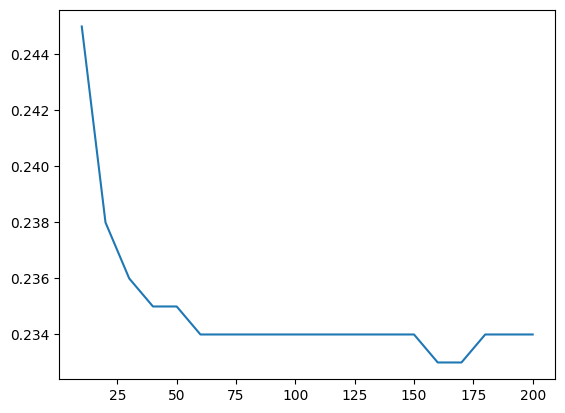

In [45]:
from matplotlib import pyplot as plt 
plt.plot(df_scores.n_estimators, df_scores.rmse)

`Answer 160`

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25


In [46]:
def train_random_forest_regressor(X, y, **kwargs):
    n_estimators = kwargs.get('n_estimators', 100)  # Default value is 100 if not provided
    random_state = kwargs.get('random_state', None)  # Default value is None if not provided
    n_jobs = kwargs.get('n_jobs', 1)  # Default value is 1 if not provided
    max_depth = kwargs.get('max_depth', None)  # Default value is None if not provided


    rfr = RandomForestRegressor(n_estimators = n_estimators, 
                                random_state = random_state, 
                                n_jobs = n_jobs,
                                max_depth = max_depth)
    rfr.fit(X, y)
    return rfr

In [47]:
def random_forest_regressor_evaluation():
    scores = []
    for max_depth in [10, 15, 20, 25]:
        for estimator in range(10, 201, 10):
            rfr = train_random_forest_regressor(X_train, y_train, 
                                                n_estimators=estimator, 
                                                random_state=1, 
                                                n_jobs=-1,
                                                max_depth=max_depth)
            y_pred = rfr.predict(X_val)
            rmse_value = rmse(y_val, y_pred)
            scores.append((max_depth, estimator, rmse_value))
    return scores

In [48]:
scores = random_forest_regressor_evaluation()

In [49]:
columns = ['max_depth', 'estimator', 'acc']
df_scores = pd.DataFrame(scores, columns=columns)

In [50]:
df_scores_pivot = df_scores.pivot(index='estimator', columns=['max_depth'], values=['acc'])
df_scores_pivot[1:10]

acc                     
max_depth     10     15     20     25
estimator                            
20         0.247  0.239  0.238  0.238
30         0.246  0.237  0.236  0.236
40         0.245  0.236  0.235  0.234
50         0.246  0.236  0.235  0.234
60         0.246  0.236  0.235  0.234
70         0.245  0.235  0.235  0.234
80         0.246  0.236  0.235  0.234
90         0.246  0.235  0.235  0.234
100        0.245  0.235  0.234  0.234

<Axes: xlabel='None-max_depth', ylabel='estimator'>

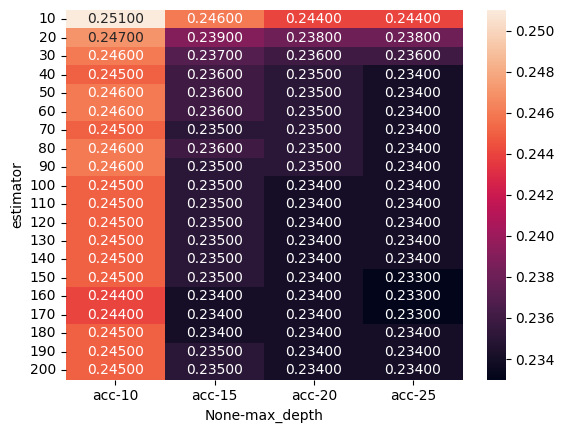

In [51]:
import seaborn as sns
sns.heatmap(df_scores_pivot, annot=True, fmt=".5f")

`Answer max_depth = 25`

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [52]:
rfr = train_random_forest_regressor(X_train, y_train, 
                                    n_estimators=10, 
                                    random_state=1, 
                                    n_jobs=-1,
                                    max_depth=20)

In [53]:
feature_importance = rfr.feature_importances_

In [54]:
feature_list = list(dv.get_feature_names_out())

In [55]:
for feature, importance in zip(feature_list, feature_importance):
    print(f"{feature}: {importance}")

households: 0.015043139111271224
housing_median_age: 0.030063286803328055
latitude: 0.10266505351248023
longitude: 0.085853413889788
median_income: 0.33548579019301683
ocean_proximity=<1H OCEAN: 0.21881985433078302
ocean_proximity=INLAND: 0.14745955406828146
population: 0.028114716700962206
total_bedrooms: 0.015433664373277032
total_rooms: 0.021061527016812055


`Answer median_income: 0.3355070433470429`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

`# Install XGBoost`

In [56]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.1/99.7 MB 1.2 MB/s eta 0:01:24
   ---------------------------------------- 1.2/99.7 MB 8.2 MB/s eta 0:00:13
   - -------------------------------------- 2.5/99.7 MB 13.4 MB/s eta 0:00:08
   - -------------------------------------- 3.7/99.7 MB 16.8 MB/s eta 0:00:06
   - -------------------------------------- 4.7/99.7 MB 18.8 MB/s eta 0:00:06
   -- ------------------------------------- 6.3/99.7 MB 21.3 MB/s eta 0:00:05
   --- -------------------------


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
# Create Dmatrix for train and validation
features = dv.get_feature_names_out()
features

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [58]:
features = ['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity_1H_OCEAN',
       'ocean_proximity_INLAND', 'population', 'total_bedrooms',
       'total_rooms']

In [59]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [60]:
for eta in range (1, 4, 1):
    eta_value = round(eta * 0.1, 1)
    xgb_params = {
        'eta': eta_value, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    rmse_value = rmse(y_val, y_pred)
    print(f"eta: {eta_value}, rmse : {rmse_value}")

eta: 0.1, rmse : 0.232
eta: 0.2, rmse : 0.23
eta: 0.3, rmse : 0.229


`Answer eta: 0.3, rmse : 0.229`